In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import arm_experiments_lib as arm_lib

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [15]:
np.random.seed(4524)
_ = torch.manual_seed(4524)

We are interested in minimizing an objective of the form 
\begin{align}
E_{q_\eta(z)}[f(z)]
\end{align}
where $z$ is a discrete random variable, so the re-parametrization trick does not apply. 

We consider a simple experiment, and apply the performance of REINFORCE, ARM, and a new proposed method. 


# The setup: 

We seek to minimize the loss function: 
\begin{align}
E_{b} \|b - p_0\|^2
\end{align}
where $b\in \{0, 1\}^d$, and each element $b_i \sim^{iid} \text{Bernoulli}(\sigma(\phi))$. We optimize over $\phi\in\mathbb{R}^n$; $\sigma(\cdot)$ is the sigmoid function. 

In [16]:
# fixed parameters
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])
d = len(p0)
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')


p0:  tensor([ 0.6000,  0.5100,  0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 



We can re-write the objective as 

\begin{align}
f(\phi) = \sum_{i=1}^d \Big\{\sigma(\phi) (1 - p_{0i})^2 + (1 - \sigma(\phi)) p_{0i}^2\Big\}
\end{align}

If $\sum_{i=1}^d(1 - p_{0i})^2 > \sum_{i=1}^d p_{0i}^2$, then the optimal $\sigma(\phi)$ is 1; otherwise, 
the optimal $\sigma(\phi)$ is 0. 

In [17]:
# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

optimal loss:  tensor(0.6705)
optimal x:  1


# Train with true gradient

We can compute the gradient of $f(\phi)$, and do simple gradient descent. 

In [18]:
# random init for phi
phi0 = torch.Tensor([0])# torch.rand(1, requires_grad=True)
phi0.requires_grad_(True)
print('init: ', phi0)

init:  tensor([ 0.])


In [19]:
lr = 1.0
n_steps = 500
loss_array_true_grad, phi_array_true_grad = \
    arm_lib.run_SGD(phi0, p0, arm_lib.get_loss, lr = lr, n_steps = n_steps)

Text(0,0.5,'loss')

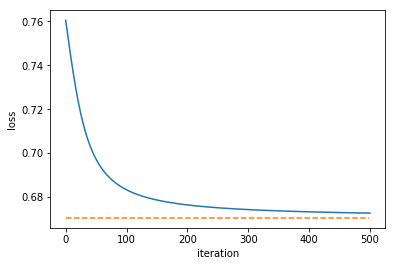

In [29]:
plt.plot(loss_array_true_grad)

# orange line is true optimal loss
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [21]:
# assert we actually descended at each step
for i in range(1, n_steps + 1): 
    assert (loss_array_true_grad[i] - loss_array_true_grad[i-1]) < 0

In [22]:
print('phi_final: ', phi_array_true_grad[-1])
print('x_final: ', sigmoid(torch.Tensor([phi_array_true_grad[-1]])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  4.400422096252441
x_final:  [0.98787665]
x_optimal:  1


# Train with reinforce gradient

Alternatively, we could evaluate stochastic gradients. The first that we consider here, is the REINFORCE estimator. 

We estimate the gradient as 
\begin{align}
g(\phi) = \|b - p_0\|^2 \nabla_\phi \log P_\phi(b), \quad b\sim P_\phi(b)
\end{align}

where $P_\phi(b) = \sigma(\phi)^{\sum b} \cdot (1 - \sigma(\phi))^{1 -\sum b}$, the probability of observing a vector $b$, when its components $b_i$ are drawn iid from $\text{Bernoulli}(\sigma(\phi))$. 
 
 We expect this gradient to have high variance. 

In [23]:
lr = 1
n_steps = 500
loss_array_reinforce, phi_array_reinforce = \
    arm_lib.run_SGD(phi0, p0, arm_lib.get_reinforce_ps_loss, lr = lr, n_steps = n_steps)

Text(0,0.5,'loss')

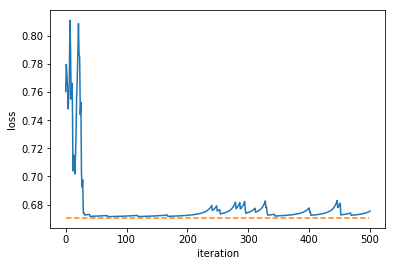

In [24]:
plt.plot(loss_array_reinforce)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [25]:
print('phi_final: ', phi_array_reinforce[-1])
print('x_final: ', sigmoid(torch.Tensor([phi_array_reinforce[-1]])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  3.5940592288970947
x_final:  [0.9732487]
x_optimal:  1


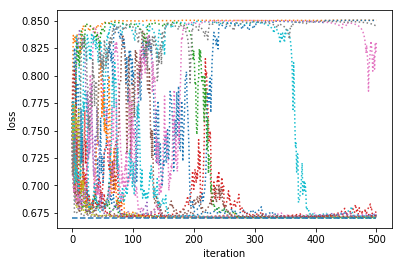

In [26]:
for i in range(20): 
    loss_array_reinforce, phi_array_reinforce = \
        arm_lib.run_SGD(phi0, p0, arm_lib.get_reinforce_ps_loss, lr = lr, n_steps = n_steps)

    plt.plot(loss_array_reinforce, ':')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


Indeed, it does not even always converge to the truth. 

# Check ARM gradient estimator

We also implement the ARM gradient estimator, detailed here: https://arxiv.org/pdf/1807.11143.pdf
        
Equation 8 of the paper suffices for our purposes here. 

In [31]:
lr = 1 
n_steps = 500
loss_array_arm, phi_array_arm = \
    arm_lib.run_SGD(phi0, p0, arm_lib.get_arm_ps_loss, lr = lr, n_steps = n_steps)

Text(0,0.5,'loss')

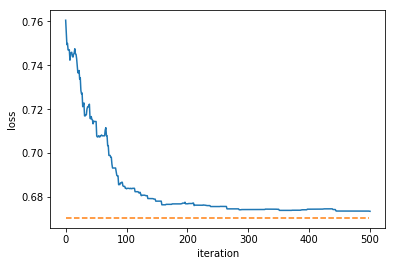

In [32]:
plt.plot(loss_array_arm)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [33]:
print('phi_final: ', phi_array_arm[-1])
print('x_final: ', sigmoid(torch.Tensor([phi_array_arm[-1]])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  4.071340084075928
x_final:  [0.9832314]
x_optimal:  1


In [34]:
# again check sensitivity to stochasticity

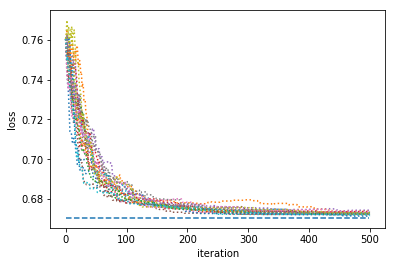

In [35]:
for i in range(20): 
    lr = 1.0
    n_steps = 500
    loss_array_arm, phi_array_arm = \
        arm_lib.run_SGD(phi0, p0, arm_lib.get_arm_ps_loss, lr = lr, n_steps = n_steps)

    plt.plot(loss_array_arm, ':')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


It does well!

# Compare all 3 methods so far

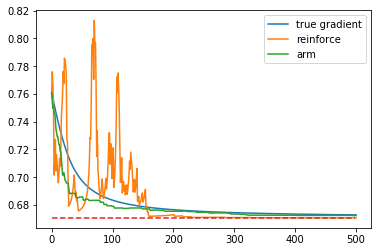

In [37]:
plt.plot(loss_array_true_grad, '-')
plt.plot(loss_array_reinforce, '-')
plt.plot(loss_array_arm, '-')
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.legend(('true gradient', 'reinforce', 'arm'))

# Mix classic and reinforce

This is the method we propose. In general, suppose our loss function is of the form 
\begin{align}
E_{q_\eta(z)}[f(z)]
\end{align}
and $z\in\{0, ..., K\}$ is discrete. 

The objective can be written as
\begin{align}
E_{q_\eta(z)}[f(z)] = \sum_{z=1}^K q_\eta(z) f(z)
\end{align}

But in many cases, $K$ is large (think SBN, for example, were the latent space of dimension $d$ can take $2^d$ distinct values), and evaluating $f(z)$ is expensive. REINFORCE gets around this problem by sampling, only one $z$ at each iteration, but as we saw, it has much too high variance. 

If we call computing the sum over $z$ and taking gradients the ``classic" method (as its common in the old VAE) literature, we propose a combination of REINFORCE and this classic method that may potentially have smaller variance. 

WOLOG (for the sake of notation), suppose that $z = 1, ..., k$ had the highest probabilities under $q_\eta$. Then
we can write the objective as 
\begin{align}
E_{q_\eta(z)}[f(z)] &= q_\eta(z \leq k) \cdot E_{q_\eta(z)}\Big[f(z)\; \big| \;z\leq k\Big] + 
                            q_\eta(z > k)\cdot E_{q_\eta(z)}\Big[f(z) \;\big|\; z > k\Big]\\
    &= \sum_{z=1}^k q_\eta(z) f(z) + q_\eta(z > k)\cdot E_{q_\eta(z)}\Big[f(z) \;\big|\; z > k\Big]
\end{align}

In other words, we sum over the first $k$ largest probabilities. To take the gradient, we use the analytic gradient for the first term; and for the second term we apply the REINFORCE estimator. 

Intuitively, we think this is a good idea because we would expect that the mass of $z$ to be concentrated around a few points -- so we simply sum those out. For the remainder, we use the REINFORCE estimator to compute the gradient of the expectation; note that this expecation is scaled by $q_\eta(z > k)$, which we said are the small probabilities, so this factor will control the variance. 

In [43]:
lr = 1
n_steps = 500
num_reinforced = 6 # this is the number of categories we DO NOT sum out
loss_array_arm, phi_array_arm = \
    arm_lib.run_SGD(phi0, p0, 
                    lambda phi, p0 : arm_lib.get_mixed_reinforce_ps_loss(phi, p0, num_reinforced), 
                    lr = lr, n_steps = n_steps)

Text(0,0.5,'loss')

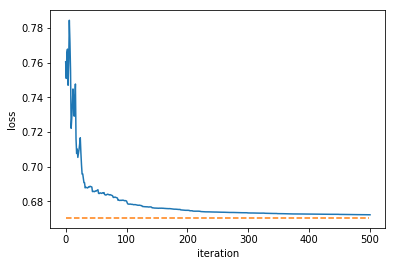

In [44]:
plt.plot(loss_array_arm)
plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')

plt.xlabel('iteration')
plt.ylabel('loss')

In [45]:
print('phi_final: ', phi_array_arm[-1])
print('x_final: ', sigmoid(torch.Tensor([phi_array_arm[-1]])).numpy())
print('x_optimal: ', x_optimal.numpy())

phi_final:  4.591126441955566
x_final:  [0.98996043]
x_optimal:  1


In [46]:
# again check sensitivity to stochasticity

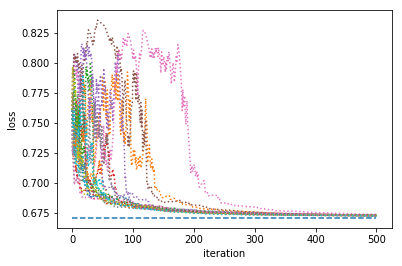

In [47]:
for i in range(20): 
    lr = 1
    n_steps = 500
    loss_array_mixed, phi_array_mixed = \
        arm_lib.run_SGD(phi0, p0, 
                    lambda phi, p0 : arm_lib.get_mixed_reinforce_ps_loss(phi, p0, num_reinforced), 
                    lr = lr, n_steps = n_steps)
    plt.plot(loss_array_mixed, ':')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


### Lets experiment with the number reinforced

In [67]:
def get_avg_paths(phi, p0, get_ps_loss, n_trials = 20, n_steps = 500, lr = 1): 
    # Function to run a few trials of SGD and get the average path 
    
    loss_path_all = np.zeros((n_trials, n_steps + 1))
    
    for i in range(n_trials): 
        loss_path, _ = \
            arm_lib.run_SGD(phi0, p0, 
                        get_ps_loss, 
                        lr = lr, n_steps = n_steps)
            
        loss_path_all[i, :] = loss_path
    
    loss_array_avg = np.mean(loss_path_all, axis = 0)
    return loss_array_avg, loss_path_all


1
2
3
4
5
6
7


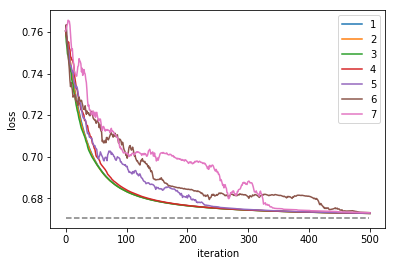

In [74]:
lr = 1
n_steps = 500

avg_loss_num_reinforce_array = np.zeros((2**d - 1, n_steps + 1))

for i in range(1, 2**d): 
    print(i)
    
    avg_loss_array, _ = \
        get_avg_paths(phi0, p0, 
                    lambda phi, p0 : arm_lib.get_mixed_reinforce_ps_loss(phi, p0, num_reinforced = i), 
                    lr = lr, n_steps = n_steps)
        
    avg_loss_num_reinforce_array[i - 1, :] = avg_loss_array
        
    plt.plot(avg_loss_array, '-')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend(('1', '2', '3', '4', '5', '6', '7'))

plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')
